In [2]:
import numpy as np 
import sacc
import matplotlib.pyplot as plt
col = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [3]:
### data

DIR_data = "../../highL_2015/data/"

def to_dl(ell):
    if type(ell) == list:
        ell = np.asarray(ell)
    return ell*(ell+1)/2/np.pi

ells_acte = [1,2,3] 
dls_acte = [1,2,3]
err_acte = [1,2,3]
# Read data from files (replace these with your actual file paths)
ells_acte[0], dls_acte[0], err_acte[0] = np.loadtxt(DIR_data + 'data_act/equa/spectrum_148x148.dat',unpack=True)
ells_acte[1], dls_acte[1], err_acte[1] = np.loadtxt(DIR_data + 'data_act/equa/spectrum_148x220.dat',unpack=True)
ells_acte[2], dls_acte[2], err_acte[2] = np.loadtxt(DIR_data + 'data_act/equa/spectrum_220x220.dat',unpack=True)

ells_acts = [1,2,3] 
dls_acts = [1,2,3]
err_acts = [1,2,3]
# Read data from files (replace these with your actual file paths)
ells_acts[0], dls_acts[0], err_acts[0] = np.loadtxt(DIR_data + 'data_act/south/spectrum_148x148.dat',unpack=True)
ells_acts[1], dls_acts[1], err_acts[1] = np.loadtxt(DIR_data + 'data_act/south/spectrum_148x220.dat',unpack=True)
ells_acts[2], dls_acts[2], err_acts[2] = np.loadtxt(DIR_data + 'data_act/south/spectrum_220x220.dat',unpack=True)

for i in range(3):
    dls_acte[i] = to_dl(ells_acte[i]) * dls_acte[i]
    dls_acts[i] = to_dl(ells_acts[i]) * dls_acts[i]
    err_acte[i] = to_dl(ells_acte[i]) * err_acte[i]
    err_acts[i] = to_dl(ells_acts[i]) * err_acts[i]
    
freqs_spt = ["90x90", "90x150", "90x220", "150x150", "150x220", "220x220"]
freqs_act = ["148x148", "148x218", "218x218"]
def read_spt_bandpower_george():
    fname = "../../highL_2015/data/data_spt/spt_bandpower.dat"
    ells = []
    Dls = []
    Dls_err = []
    i = -1
    with open(fname, 'r') as f:
        lines = f.readlines()
        for line in lines:
            ell, dl, dls_err = line.split()
            if int(ell) == 2106:
                i+=1
                ells.append([])
                Dls.append([])
                Dls_err.append([])
            ells[i].append(int(ell))
            Dls[i].append(float(dl))
            Dls_err[i].append(float(dls_err))
    for i in range(len(ells)):
        ells[i] = np.asarray(ells[i])
        Dls[i] = np.asarray(Dls[i])
        Dls_err[i] = np.asarray(Dls_err[i])
    return ells, Dls, Dls_err

def read_spt_bandpower_reichardt():
    fname = "./Reichardt_bps.dat"
    ells = []
    Dls = []
    Dls_err = []
    for i, fr in enumerate(freqs_spt):
        ls, dls, err = np.loadtxt(fname, usecols=(1,2+i*2,2*i+3), unpack=True)
        if i == 0 :
            ells.append(ls[:-2])
            Dls.append(dls[:-2])
            Dls_err.append(err[:-2])
        else:
            ells.append(ls)
            Dls.append(dls)
            Dls_err.append(err)
    return ells, Dls, Dls_err

In [4]:
### defs

def read_min(fname):
    data_dict = {}
    with open(fname, 'r') as file:
        lines = file.readlines()[3:]
        for line in lines:
#             if not line.strip():  # Check for empty line
#                 break
            parts = line.split()
            if len(parts) >= 3:
                key = parts[2]
                value = parts[1]
                data_dict[key] = float(value)
    return data_dict

def cosmo_params(params):
    cosmo_pars = {}
    for key in ["H0","ns", "ombh2", "omch2", "tau"]:
        cosmo_pars[key] = params[key]
    cosmo_pars["logA"] = {"value": params["logA"], "drop": True}
    cosmo_pars["As"] = {"value": "lambda logA: 1e-10*np.exp(logA)"}
    return cosmo_pars
from mflike import PlikMFLike, MFLike
from cobaya.yaml import yaml_load_file
import camb
import os

def get_dls_obs_highL(directory, chain): 
    try:
        params = read_min(os.path.join("../", directory, "../outputs/chains", f"{chain}.minimum"))
    except FileNotFoundError: 
        params = read_min(os.path.join("../", directory, "outputs/chains", f"{chain}.minimum"))
    info_from_yaml = yaml_load_file(os.path.join("../", directory,"likelihood_mflike_highL.yaml"))
    my_mflike = MFLike(info_from_yaml['mflike.MFLike'])
    camb_cosmo = {k: v for k, v in cosmo_params(params).items() if k not in ["logA", "As"]}
    camb_cosmo.update({"As": 1e-10 * np.exp(cosmo_params(params)["logA"]["value"]),"lmax": 6000,"lens_potential_accuracy": 1})
    pars = camb.set_params(**camb_cosmo)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")
    cl_dict = {k: powers["total"][:, v] for k, v in {"tt": 0, "ee": 1, "te": 3, "bb": 2}.items()}
    cl_dict['tt'][6000:] = 0.
    cl_dict['ell'] = np.linspace(0,6000,6001).astype('int')
    Dls = {}
    for s, _ in my_mflike.lcuts.items():
        dl = np.zeros_like(my_mflike.l_bpws)
        dl[:my_mflike.lmax_theory+1] = cl_dict[s][:my_mflike.lmax_theory+1]
        Dls[s] = dl
    DlsObs = my_mflike.ThFo.get_modified_theory(Dls, **params)
    component_list = my_mflike.ThFo.fg_component_list
    fg_dict = my_mflike.ThFo._get_foreground_model(**params)
    DlsObs_window = {}
    leff = {}
    for m in my_mflike.spec_meta:
        w = m["bpw"].weight.T
        leff["tt", m["t1"], m["t2"]] = m["leff"]
        DlsObs_window["tt", m["t1"], m["t2"]] = w @ DlsObs["tt", m["t1"], m["t2"]]
    DlsObs_contribution = {}
    for key in component_list.keys():
        exp = key[0]
        cl = key[1]
        for component in component_list[key]:
            for m in my_mflike.spec_meta:
                if m["t1"][:4] == exp and m["t2"][:4] == exp:
                    DlsObs_contribution[cl,m["t1"], m["t2"], component] = fg_dict[cl, component, m["t1"],m["t2"]]
    return my_mflike.l_bpws, DlsObs,DlsObs_contribution, component_list, leff, DlsObs_window

def get_dls_params(directory, params): 
    info_from_yaml = yaml_load_file(os.path.join("../", directory,"likelihood_mflike_highL.yaml"))
    my_mflike = MFLike(info_from_yaml['mflike.MFLike'])
    camb_cosmo = {k: v for k, v in cosmo_params(params).items() if k not in ["logA", "As"]}
    camb_cosmo.update({"As": 1e-10 * np.exp(cosmo_params(params)["logA"]["value"]),"lmax": 6000,"lens_potential_accuracy": 1})
    pars = camb.set_params(**camb_cosmo)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")
    cl_dict = {k: powers["total"][:, v] for k, v in {"tt": 0, "ee": 1, "te": 3, "bb": 2}.items()}
    cl_dict['tt'][6000:] = 0.
    cl_dict['ell'] = np.linspace(0,6000,6001).astype('int')
    Dls = {}
    for s, _ in my_mflike.lcuts.items():
        dl = np.zeros_like(my_mflike.l_bpws)
        dl[:my_mflike.lmax_theory+1] = cl_dict[s][:my_mflike.lmax_theory+1]
        Dls[s] = dl
    DlsObs = my_mflike.ThFo.get_modified_theory(Dls, **params)
    component_list = my_mflike.ThFo.fg_component_list
    fg_dict = my_mflike.ThFo._get_foreground_model(**params)
    DlsObs_contribution = {}
    for key in component_list.keys():
        exp = key[0]
        cl = key[1]
        for component in component_list[key]:
            for m in my_mflike.spec_meta:
                if m["t1"][:4] == exp and m["t2"][:4] == exp:
                    DlsObs_contribution[cl,m["t1"], m["t2"], component] = fg_dict[cl, component, m["t1"],m["t2"]]
    return my_mflike.l_bpws, DlsObs, DlsObs_contribution, component_list


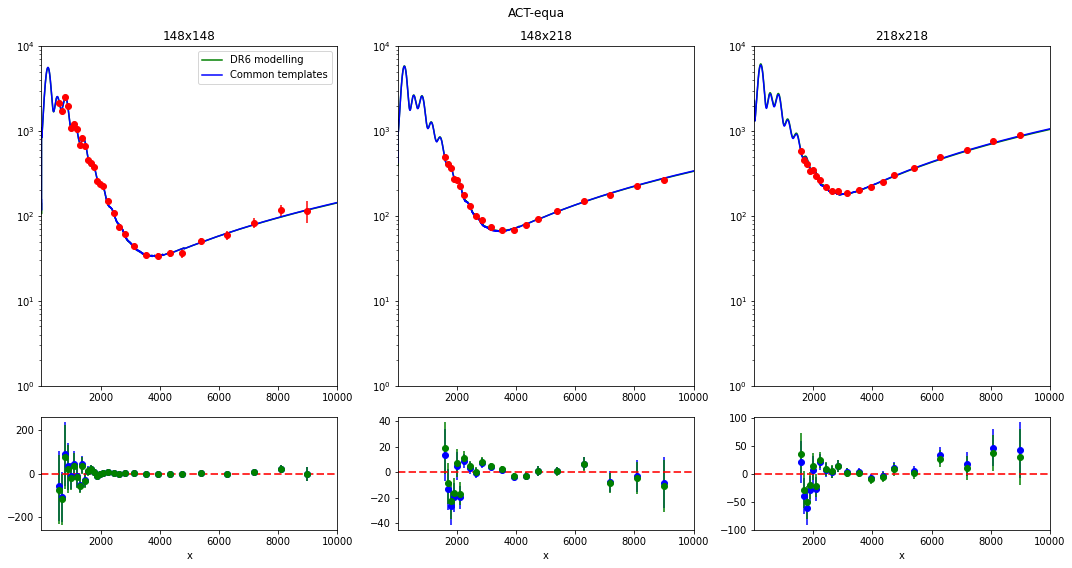

In [5]:
### ACT-Equa

# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0, 0].errorbar(ells_acte[0], dls_acte[0], yerr=err_acte[0], fmt='o', c='r')
axs[0, 1].errorbar(ells_acte[1], dls_acte[1], yerr=err_acte[1], fmt='o', c='r')
axs[0, 2].errorbar(ells_acte[2], dls_acte[2], yerr=err_acte[2], fmt='o', c='r')


ell, DlsObs_dr6, _,_,leff, DlsObs_window_dr6 = get_dls_obs_highL("DR6_modelling/MBAC_reichardt_plik", "MBAC_reichardt_plik_fixedcosmo")
axs[0, 0].plot(ell, DlsObs_dr6["tt", "acte_148", "acte_148"], c='g', label="DR6 modelling")
axs[0, 1].plot(ell, DlsObs_dr6["tt", "acte_148", "acte_220"], c='g')
axs[0, 2].plot(ell, DlsObs_dr6["tt", "acte_220", "acte_220"], c='g')

ell, DlsObs_common,_,_, leff, DlsObs_window_common = get_dls_obs_highL("common_templates/MBAC_reichardt_plik", "MBAC_reichardt_plik_fixedcosmo")
axs[0, 0].plot(ell, DlsObs_common["tt", "acte_148", "acte_148"], c='b', label="Common templates")
axs[0, 1].plot(ell, DlsObs_common["tt", "acte_148", "acte_220"], c='b')
axs[0, 2].plot(ell, DlsObs_common["tt", "acte_220", "acte_220"], c='b')

axs[1, 0].errorbar(ells_acte[0], dls_acte[0] - DlsObs_window_dr6["tt", "acte_148", "acte_148"], yerr=err_acte[0], fmt='o', c='b')
axs[1, 1].errorbar(ells_acte[1], dls_acte[1] - DlsObs_window_dr6["tt", "acte_148", "acte_220"], yerr=err_acte[1], fmt='o', c='b')
axs[1, 2].errorbar(ells_acte[2], dls_acte[2] - DlsObs_window_dr6["tt", "acte_220", "acte_220"], yerr=err_acte[2], fmt='o', c='b')

axs[1, 0].errorbar(ells_acte[0], dls_acte[0] - DlsObs_window_common["tt", "acte_148", "acte_148"], yerr=err_acte[0], fmt='o', c='g')
axs[1, 1].errorbar(ells_acte[1], dls_acte[1] - DlsObs_window_common["tt", "acte_148", "acte_220"], yerr=err_acte[1], fmt='o', c='g')
axs[1, 2].errorbar(ells_acte[2], dls_acte[2] - DlsObs_window_common["tt", "acte_220", "acte_220"], yerr=err_acte[2], fmt='o', c='g')

# Add titles and labels
axs[0,0].legend()
for i in range(3):
#     axs[0, i].set_title(f'Data {i+1}')
#     axs[1, i].set_title(f'Residuals {i+1}')
    axs[1, i].set_xlabel('x')
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,10000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[0, i].set_xlim(2, 1e4)
#     axs[0, i].set_ylim(-, 1e4)
    axs[1, i].set_xlim(2, 1e4)
    axs[0,i].set_title(f"{freqs_act[i]}")
    
    
plt.suptitle("ACT-equa")
# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig("../figures/residuals_acte.png")
plt.show()


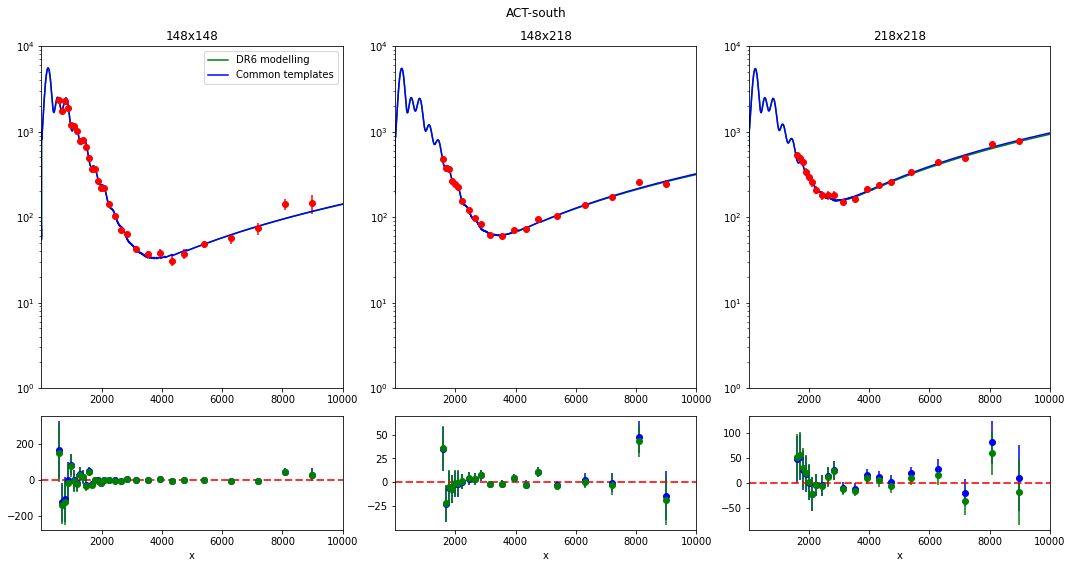

In [6]:
###ACT - South


# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0, 0].errorbar(ells_acts[0], dls_acts[0], yerr=err_acts[0], fmt='o', c='r')
axs[0, 1].errorbar(ells_acts[1], dls_acts[1], yerr=err_acts[1], fmt='o', c='r')
axs[0, 2].errorbar(ells_acts[2], dls_acts[2], yerr=err_acts[2], fmt='o', c='r')

ell, DlsObs_dr6, _,_,leff, DlsObs_window_dr6 = get_dls_obs_highL("DR6_modelling/MBAC_reichardt_plik", "MBAC_reichardt_plik_fixedcosmo")
axs[0, 0].plot(ell, DlsObs_dr6["tt", "acts_148", "acts_148"], c='g', label="DR6 modelling")
axs[0, 1].plot(ell, DlsObs_dr6["tt", "acts_148", "acts_220"], c='g')
axs[0, 2].plot(ell, DlsObs_dr6["tt", "acts_220", "acts_220"], c='g')

ell, DlsObs_common,_,_, leff, DlsObs_window_common = get_dls_obs_highL("common_templates/MBAC_reichardt_plik", "MBAC_reichardt_plik_fixedcosmo")
axs[0, 0].plot(ell, DlsObs_common["tt", "acts_148", "acts_148"], c='b', label="Common templates")
axs[0, 1].plot(ell, DlsObs_common["tt", "acts_148", "acts_220"], c='b')
axs[0, 2].plot(ell, DlsObs_common["tt", "acts_220", "acts_220"], c='b')


axs[1, 0].errorbar(ells_acts[0], dls_acts[0] - DlsObs_window_dr6["tt", "acts_148", "acts_148"], yerr=err_acts[0], fmt='o', c='b')
axs[1, 1].errorbar(ells_acts[1], dls_acts[1] - DlsObs_window_dr6["tt", "acts_148", "acts_220"], yerr=err_acts[1], fmt='o', c='b')
axs[1, 2].errorbar(ells_acts[2], dls_acts[2] - DlsObs_window_dr6["tt", "acts_220", "acts_220"], yerr=err_acts[2], fmt='o', c='b')

axs[1, 0].errorbar(ells_acts[0], dls_acts[0] - DlsObs_window_common["tt", "acts_148", "acts_148"], yerr=err_acts[0], fmt='o', c='g')
axs[1, 1].errorbar(ells_acts[1], dls_acts[1] - DlsObs_window_common["tt", "acts_148", "acts_220"], yerr=err_acts[1], fmt='o', c='g')
axs[1, 2].errorbar(ells_acts[2], dls_acts[2] - DlsObs_window_common["tt", "acts_220", "acts_220"], yerr=err_acts[2], fmt='o', c='g')

# Add titles and labels
axs[0,0].legend()
for i in range(3):
#     axs[0, i].set_title(f'Data {i+1}')
#     axs[1, i].set_title(f'Residuals {i+1}')
    axs[1, i].set_xlabel('x')
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,10000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[0, i].set_xlim(2, 1e4)
#     axs[0, i].set_ylim(-, 1e4)
    axs[1, i].set_xlim(2, 1e4)
    axs[0,i].set_title(f"{freqs_act[i]}")
    
    
plt.suptitle("ACT-south")
# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig("../figures/residuals_acts.png")
plt.show()


In [ ]:
### SPT-George 

# Read data from files (replace these with your actual file paths)
ells_spt, dls_spt, err_spt = read_spt_bandpower_george()
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0, 0].errorbar(ells_spt[0], dls_spt[0], yerr=err_spt[0], fmt='o', c='r')
axs[0, 1].errorbar(ells_spt[1], dls_spt[1], yerr=err_spt[1], fmt='o', c='r')
axs[0, 2].errorbar(ells_spt[2], dls_spt[2], yerr=err_spt[2], fmt='o', c='r')

ell, DlsObs_highL, leff, DlsObs_window_highL = get_dls_obs_highL("highL_plik", "plik_highL_prior")
axs[0, 0].plot(ell, DlsObs_highL["tt", "sptg_90", "sptg_90"], c='k', label="highL")
axs[0, 1].plot(ell, DlsObs_highL["tt", "sptg_90", "sptg_150"], c='k')
axs[0, 2].plot(ell, DlsObs_highL["tt", "sptg_90", "sptg_220"], c='k')

ell, DlsObs_dr6, leff, DlsObs_window_dr6 = get_dls_obs_highL("highL_plik_commonSZCIB_fixedTc_dr6poisson", "plik_highL_bandeff")
axs[0, 0].plot(ell, DlsObs_dr6["tt", "sptg_90", "sptg_90"], c='b', label="DR6 modelling")
axs[0, 1].plot(ell, DlsObs_dr6["tt", "sptg_90", "sptg_150"], c='b')
axs[0, 2].plot(ell, DlsObs_dr6["tt", "sptg_90", "sptg_220"], c='b')

ell, DlsObs_common, leff, DlsObs_window_common = get_dls_obs_highL("highL_plik_commonSZCIB_fixedTc", "plik_highL_bandeff")
axs[0, 0].plot(ell, DlsObs_common["tt", "sptg_90", "sptg_90"], c='g', label="common templates")
axs[0, 1].plot(ell, DlsObs_common["tt", "sptg_90", "sptg_150"], c='g')
axs[0, 2].plot(ell, DlsObs_common["tt", "sptg_90", "sptg_220"], c='g')

# Plot residuals
axs[1, 0].errorbar(ells_spt[0], dls_spt[0] - DlsObs_window_highL["tt", "sptg_90", "sptg_90"], yerr=err_spt[0], fmt='o', c='k')
axs[1, 1].errorbar(ells_spt[1], dls_spt[1] - DlsObs_window_highL["tt", "sptg_90", "sptg_150"], yerr=err_spt[1], fmt='o', c='k')
axs[1, 2].errorbar(ells_spt[2], dls_spt[2] - DlsObs_window_highL["tt", "sptg_90", "sptg_220"], yerr=err_spt[2], fmt='o', c='k')

axs[1, 0].errorbar(ells_spt[0], dls_spt[0] - DlsObs_window_dr6["tt", "sptg_90", "sptg_90"], yerr=err_spt[0], fmt='o', c='b')
axs[1, 1].errorbar(ells_spt[1], dls_spt[1] - DlsObs_window_dr6["tt", "sptg_90", "sptg_150"], yerr=err_spt[1], fmt='o', c='b')
axs[1, 2].errorbar(ells_spt[2], dls_spt[2] - DlsObs_window_dr6["tt", "sptg_90", "sptg_220"], yerr=err_spt[2], fmt='o', c='b')

axs[1, 0].errorbar(ells_spt[0], dls_spt[0] - DlsObs_window_common["tt", "sptg_90", "sptg_90"], yerr=err_spt[0], fmt='o', c='g')
axs[1, 1].errorbar(ells_spt[1], dls_spt[1] - DlsObs_window_common["tt", "sptg_90", "sptg_150"], yerr=err_spt[1], fmt='o', c='g')
axs[1, 2].errorbar(ells_spt[2], dls_spt[2] - DlsObs_window_common["tt", "sptg_90", "sptg_220"], yerr=err_spt[2], fmt='o', c='g')

# Add titles and labels
axs[0,0].legend()
for i in range(3):
#     axs[0, i].set_title(f'Data {i+1}')
#     axs[1, i].set_title(f'Residuals {i+1}')
    axs[1, i].set_xlabel('x')
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,11000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[0, i].set_xlim(2, 11000)
#     axs[0, i].set_ylim(-, 1e4)
    axs[1, i].set_xlim(2, 11000)
    axs[0,i].set_title(f"{freqs_spt[i]}")
    
plt.suptitle("SPTg")
# Adjust layout
plt.tight_layout()
plt.savefig("../figures/residuals_sptg1.png")
# Show the plot
plt.show()

In [ ]:
### SPT-George 

# Read data from files (replace these with your actual file paths)
ells_spt, dls_spt, err_spt = read_spt_bandpower_george()
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0, 0].errorbar(ells_spt[3], dls_spt[3], yerr=err_spt[3], fmt='o', c='r')
axs[0, 1].errorbar(ells_spt[4], dls_spt[4], yerr=err_spt[4], fmt='o', c='r')
axs[0, 2].errorbar(ells_spt[5], dls_spt[5], yerr=err_spt[5], fmt='o', c='r')

ell, DlsObs_highL, leff, DlsObs_window_highL = get_dls_obs_highL("highL_plik", "plik_highL_prior")
axs[0, 0].plot(ell, DlsObs_highL["tt", "sptg_150", "sptg_150"], c='k', label="highL")
axs[0, 1].plot(ell, DlsObs_highL["tt", "sptg_150", "sptg_220"], c='k')
axs[0, 2].plot(ell, DlsObs_highL["tt", "sptg_220", "sptg_220"], c='k')

ell, DlsObs_dr6, leff, DlsObs_window_dr6 = get_dls_obs_highL("highL_plik_commonSZCIB_fixedTc_dr6poisson", "plik_highL_bandeff")
axs[0, 0].plot(ell, DlsObs_dr6["tt", "sptg_150", "sptg_150"], c='b', label="DR6 modelling")
axs[0, 1].plot(ell, DlsObs_dr6["tt", "sptg_150", "sptg_220"], c='b')
axs[0, 2].plot(ell, DlsObs_dr6["tt", "sptg_220", "sptg_220"], c='b')

ell, DlsObs_common, leff, DlsObs_window_common = get_dls_obs_highL("highL_plik_commonSZCIB_fixedTc", "plik_highL_bandeff")
axs[0, 0].plot(ell, DlsObs_common["tt", "sptg_150", "sptg_150"], c='g', label="Common templates")
axs[0, 1].plot(ell, DlsObs_common["tt", "sptg_150", "sptg_220"], c='g')
axs[0, 2].plot(ell, DlsObs_common["tt", "sptg_220", "sptg_220"], c='g')

# Plot residuals
axs[1, 0].errorbar(ells_spt[3], dls_spt[3] - DlsObs_window_highL["tt", "sptg_150", "sptg_150"], yerr=err_spt[3], fmt='o', c='k')
axs[1, 1].errorbar(ells_spt[4], dls_spt[4] - DlsObs_window_highL["tt", "sptg_150", "sptg_220"], yerr=err_spt[4], fmt='o', c='k')
axs[1, 2].errorbar(ells_spt[5], dls_spt[5] - DlsObs_window_highL["tt", "sptg_220", "sptg_220"], yerr=err_spt[5], fmt='o', c='k')

axs[1, 0].errorbar(ells_spt[3], dls_spt[3] - DlsObs_window_dr6["tt", "sptg_150", "sptg_150"], yerr=err_spt[3], fmt='o', c='b')
axs[1, 1].errorbar(ells_spt[4], dls_spt[4] - DlsObs_window_dr6["tt", "sptg_150", "sptg_220"], yerr=err_spt[4], fmt='o', c='b')
axs[1, 2].errorbar(ells_spt[5], dls_spt[5] - DlsObs_window_dr6["tt", "sptg_220", "sptg_220"], yerr=err_spt[5], fmt='o', c='b')

axs[1, 0].errorbar(ells_spt[3], dls_spt[3] - DlsObs_window_common["tt", "sptg_150", "sptg_150"], yerr=err_spt[3], fmt='o', c='g')
axs[1, 1].errorbar(ells_spt[4], dls_spt[4] - DlsObs_window_common["tt", "sptg_150", "sptg_220"], yerr=err_spt[4], fmt='o', c='g')
axs[1, 2].errorbar(ells_spt[5], dls_spt[5] - DlsObs_window_common["tt", "sptg_220", "sptg_220"], yerr=err_spt[5], fmt='o', c='g')

# Add titles and labels
axs[0,0].legend()
for i in range(3):
#     axs[0, i].set_title(f'Data {i+1}')
#     axs[1, i].set_title(f'Residuals {i+1}')
    axs[1, i].set_xlabel('x')
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,11000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[0, i].set_xlim(2, 11000)
#     axs[0, i].set_ylim(-, 1e4)
    axs[1, i].set_xlim(2, 11000)
    axs[0,i].set_title(f"{freqs_spt[3+i]}")
    
plt.suptitle("SPTg")
# Adjust layout
plt.tight_layout()
plt.savefig("../figures/residuals_sptg2.png")
# Show the plot
plt.show()

In [40]:
params = {'H0': 67.32,'logA': 3.0448,'ns': 0.96605,'ombh2': 0.022383,'omch2': 0.12011,'tau': 0.0543,
          'a_tSZ': 3.4,'a_kSZ': 3.,'a_CIB': 4.02,'xi': 0.0,'beta_c': 2.2,'T_dc': 25.,
          'a_gtt_as': 0.,'a_gtt_ae': 0.,'aps_148': 12.,'aps_218': 75.,'rpsa': 0.9,'a_CIBp': 7.2,
          'beta_r': -2.7,'beta_p': 1.4,'a_r': 1.01,'a_gtt_spt': 2.1,'T_dp': 25.,
          'cal_acts_148': 1.0,'cal_acts_220': 1.0,'cal_acte_148': 1.0,'cal_acte_220': 0.9,
          'cal_sptr_90': 1.01 ,'cal_sptr_150': 1.01,'cal_sptr_220': 1.01 
        }

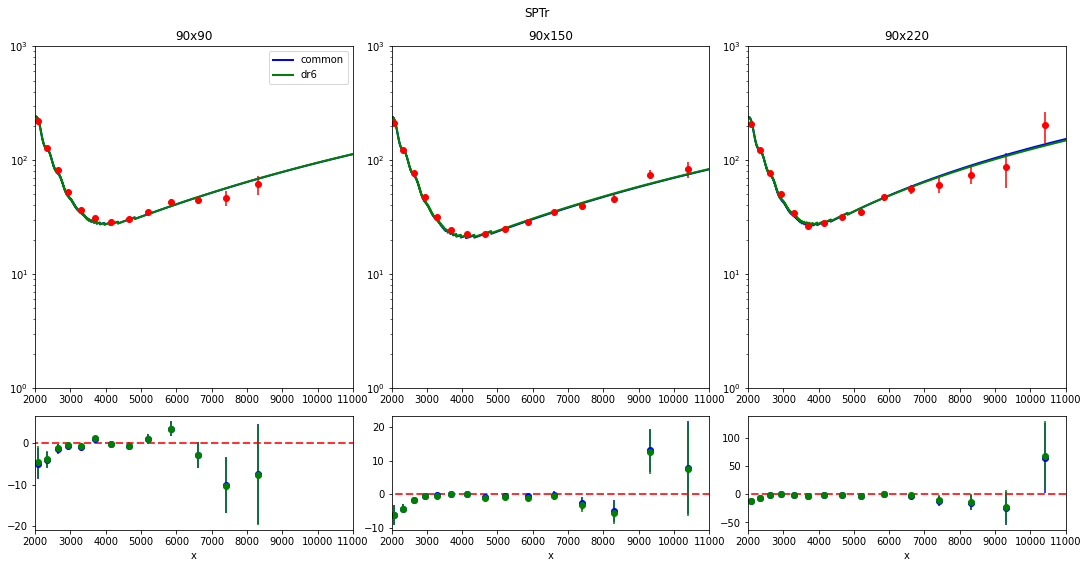

In [7]:
### SPT-Reichardt 

# Read data from files (replace these with your actual file paths)
ells_spt, dls_spt, err_spt = read_spt_bandpower_reichardt()
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0, 0].errorbar(ells_spt[0], dls_spt[0], yerr=err_spt[0], fmt='o', c='r')
axs[0, 1].errorbar(ells_spt[1], dls_spt[1], yerr=err_spt[1], fmt='o', c='r')
axs[0, 2].errorbar(ells_spt[2], dls_spt[2], yerr=err_spt[2], fmt='o', c='r')

ell, DlsObs_common, comp, lst, leff, DlsObs_window_common = get_dls_obs_highL("common_templates/MBAC_reichardt_plik", "MBAC_reichardt_plik_fixedcosmo")
ell, DlsObs_dr6, comp, lst, leff, DlsObs_window_dr6 = get_dls_obs_highL("DR6_modelling/MBAC_reichardt_plik", "MBAC_reichardt_plik_fixedcosmo")

axs[0, 0].plot(ell, DlsObs_common["tt", "sptr_90", "sptr_90"], c='b', label="common", lw=2)
axs[0, 1].plot(ell, DlsObs_common["tt", "sptr_90", "sptr_150"], c='b', lw=2)
axs[0, 2].plot(ell, DlsObs_common["tt", "sptr_90", "sptr_220"], c='b', lw=2)

    
axs[1, 0].errorbar(ells_spt[0], dls_spt[0] - DlsObs_window_common["tt", "sptr_90", "sptr_90"], yerr=err_spt[0], fmt='o', c='b')
axs[1, 1].errorbar(ells_spt[1], dls_spt[1] - DlsObs_window_common["tt", "sptr_90", "sptr_150"], yerr=err_spt[1], fmt='o', c='b')
axs[1, 2].errorbar(ells_spt[2], dls_spt[2] - DlsObs_window_common["tt", "sptr_90", "sptr_220"], yerr=err_spt[2], fmt='o', c='b')

axs[0, 0].plot(ell, DlsObs_dr6["tt", "sptr_90", "sptr_90"], c='g', label="dr6", lw=2)
axs[0, 1].plot(ell, DlsObs_dr6["tt", "sptr_90", "sptr_150"], c='g', lw=2)
axs[0, 2].plot(ell, DlsObs_dr6["tt", "sptr_90", "sptr_220"], c='g', lw=2)

    
axs[1, 0].errorbar(ells_spt[0], dls_spt[0] - DlsObs_window_dr6["tt", "sptr_90", "sptr_90"], yerr=err_spt[0], fmt='o', c='g')
axs[1, 1].errorbar(ells_spt[1], dls_spt[1] - DlsObs_window_dr6["tt", "sptr_90", "sptr_150"], yerr=err_spt[1], fmt='o', c='g')
axs[1, 2].errorbar(ells_spt[2], dls_spt[2] - DlsObs_window_dr6["tt", "sptr_90", "sptr_220"], yerr=err_spt[2], fmt='o', c='g')

# Add titles and labels
axs[0,0].legend()
for i in range(3):
#     axs[0, i].set_title(f'Data {i+1}')
#     axs[1, i].set_title(f'Residuals {i+1}')
    axs[1, i].set_xlabel('x')
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,11000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e3)
    axs[0, i].set_xlim(2000, 11000)
#     axs[0, i].set_ylim(-, 1e4)
    axs[1, i].set_xlim(2000, 11000)
    axs[0,i].set_title(f"{freqs_spt[i]}")
    
plt.suptitle("SPTr")

# Adjust layout
plt.tight_layout()
plt.savefig("../figures/residuals_sptr1.png")

# Show the plot
plt.show()

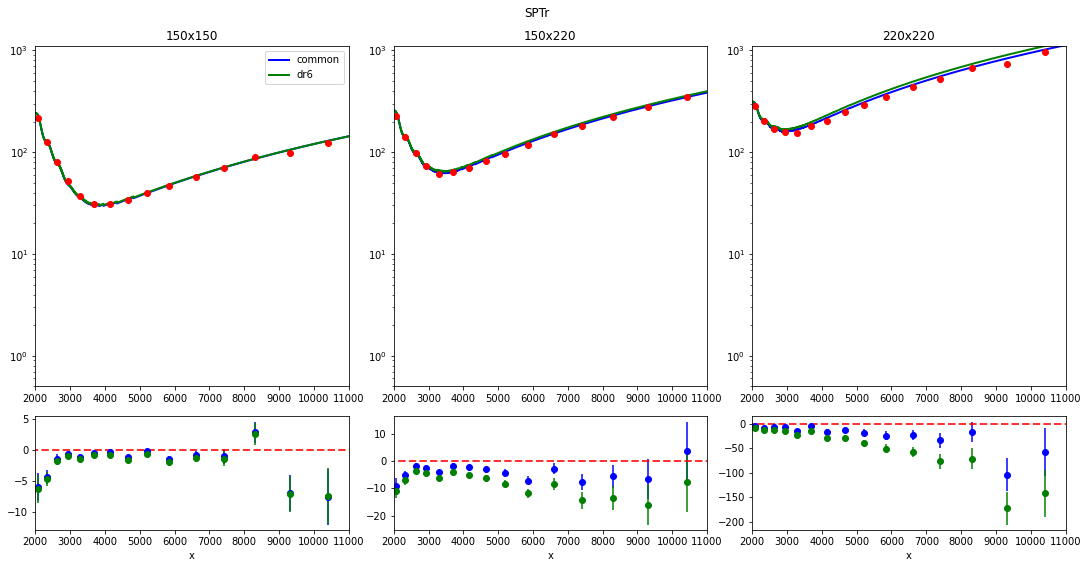

In [8]:
### SPT-Reichardt 

# Read data from files (replace these with your actual file paths)
ells_spt, dls_spt, err_spt = read_spt_bandpower_reichardt()
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0, 0].errorbar(ells_spt[3], dls_spt[3], yerr=err_spt[3], fmt='o', c='r')
axs[0, 1].errorbar(ells_spt[4], dls_spt[4], yerr=err_spt[4], fmt='o', c='r')
axs[0, 2].errorbar(ells_spt[5], dls_spt[5], yerr=err_spt[5], fmt='o', c='r')

ell, DlsObs_common, comp, lst, leff, DlsObs_window_common = get_dls_obs_highL("common_templates/MBAC_reichardt_plik", "MBAC_reichardt_plik_fixedcosmo")
ell, DlsObs_dr6, comp, lst, leff, DlsObs_window_dr6 = get_dls_obs_highL("DR6_modelling/MBAC_reichardt_plik", "MBAC_reichardt_plik_fixedcosmo")

axs[0, 0].plot(ell, DlsObs_common["tt", "sptr_150", "sptr_150"], lw=2, c='b', label="common")
axs[0, 1].plot(ell, DlsObs_common["tt", "sptr_150", "sptr_220"], lw=2, c='b')
axs[0, 2].plot(ell, DlsObs_common["tt", "sptr_220", "sptr_220"], lw=2, c='b')

# Plot residuals
axs[1, 0].errorbar(ells_spt[3], dls_spt[3] - DlsObs_window_common["tt", "sptr_150", "sptr_150"], yerr=err_spt[3], fmt='o', c='b')
axs[1, 1].errorbar(ells_spt[4], dls_spt[4] - DlsObs_window_common["tt", "sptr_150", "sptr_220"], yerr=err_spt[4], fmt='o', c='b')
axs[1, 2].errorbar(ells_spt[5], dls_spt[5] - DlsObs_window_common["tt", "sptr_220", "sptr_220"], yerr=err_spt[5], fmt='o', c='b')

axs[0, 0].plot(ell, DlsObs_dr6["tt", "sptr_150", "sptr_150"], lw=2, c='g', label="dr6")
axs[0, 1].plot(ell, DlsObs_dr6["tt", "sptr_150", "sptr_220"], lw=2, c='g')
axs[0, 2].plot(ell, DlsObs_dr6["tt", "sptr_220", "sptr_220"], lw=2, c='g')

# Plot residuals
axs[1, 0].errorbar(ells_spt[3], dls_spt[3] - DlsObs_window_dr6["tt", "sptr_150", "sptr_150"], yerr=err_spt[3], fmt='o', c='g')
axs[1, 1].errorbar(ells_spt[4], dls_spt[4] - DlsObs_window_dr6["tt", "sptr_150", "sptr_220"], yerr=err_spt[4], fmt='o', c='g')
axs[1, 2].errorbar(ells_spt[5], dls_spt[5] - DlsObs_window_dr6["tt", "sptr_220", "sptr_220"], yerr=err_spt[5], fmt='o', c='g')

# Add titles and labels
axs[0,0].legend()
for i in range(3):
#     axs[0, i].set_title(f'Data {i+1}')
#     axs[1, i].set_title(f'Residuals {i+1}')
    axs[1, i].set_xlabel('x')
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,11000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(.5, 1.1e3)
    axs[0, i].set_xlim(2000, 11000)
#     axs[0, i].set_ylim(-, 1e4)
    axs[1, i].set_xlim(2000, 11000)
    axs[0,i].set_title(f"{freqs_spt[i+3]}")
    
plt.suptitle("SPTr")
# Adjust layout

plt.tight_layout()
# Show the plot
plt.savefig("../figures/residuals_sptr2.png")

plt.show()

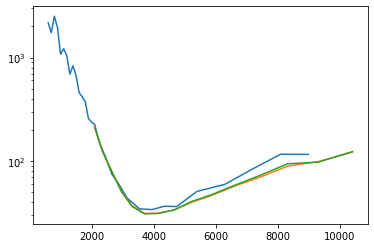

In [52]:
plt.figure()
ells_sptr, dls_sptr, err_sptr = read_spt_bandpower_reichardt()
ells_sptg, dls_sptg, err_sptg = read_spt_bandpower_george()

plt.plot(ells_acte[0], dls_acte[0])
plt.plot(ells_sptr[3], dls_sptr[3])
plt.plot(ells_sptg[3], dls_sptg[3])

plt.yscale('log')
plt.show()
